In [62]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [38]:
bairro = gpd.read_file('../../GIS/BAIRRO_POPULAR/BAIRRO_POPULAR.shp')
quadra = gpd.read_file('QUADRA_CTM/QUADRA_CTM.shp')
onibus = gpd.read_file('PONTO_ONIBUS/PONTO_ONIBUS.shp')
vias = gpd.read_file('../../GIS/infraurbana_viario_redeviariasimplificada/infraurbana_viario_redeviariasimplificada.shp')
vias_locais = gpd.read_file('../../GIS/CENTRALIDADE_LOCAL_11181/CENTRALIDADE_LOCAL_11181.shp')

In [39]:
quadra_prado = gpd.read_file('quadra_prado.shp')
vias_locais_prado = gpd.read_file('vias_locais_prado.shp')

<AxesSubplot:>

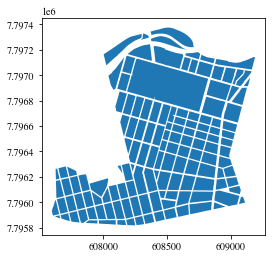

In [40]:
#quadra_prado = gpd.overlay(quadra, bairro[bairro['NOME']=='Prado'], how='intersection')
#quadra_prado.to_file('quadra_prado.shp')
quadra_prado.plot()

<AxesSubplot:>

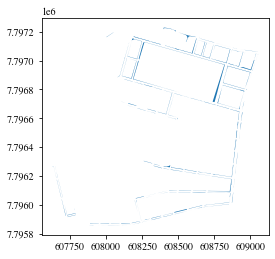

In [41]:
#vias_locais_prado = gpd.overlay(vias_locais, quadra_prado, how='intersection')
#vias_locais_prado.to_file('vias_locais_prado.shp')
vias_locais_prado.plot()

In [42]:
# ônibus do Prado
onibus_prado = onibus.sjoin_nearest(quadra_prado, how='left', max_distance = 15,
                                      distance_col='dist_prado')
onibus_prado = onibus_prado[onibus_prado['dist_prado'].notnull()]
onibus_prado.drop(columns=['index_right'],inplace=True)

# ônibus da Amazonas
onibus_amazonas = onibus_prado.sjoin_nearest(vias[vias['Nome']=='Av. Amazonas'], 
                                       how='left', max_distance = 20,
                                      distance_col='dist_amazonas')
onibus_amazonas = onibus_amazonas[onibus_amazonas['dist_amazonas'].notnull()]
onibus_amazonas['cat']='Ônibus da Av. Amazonas'

# ônibus da Contorno
onibus_contorno = onibus_prado.sjoin_nearest(vias[vias['Nome']=='Av. do Contorno'], 
                                       how='left', max_distance = 20,
                                      distance_col='dist_contorno')
onibus_contorno = onibus_contorno[onibus_contorno['dist_contorno'].notnull()]
onibus_contorno['cat']='Ônibus da Av. do Contorno'

# ônibus da Platina
onibus_platina = onibus_prado.sjoin_nearest(vias_locais[vias_locais['NOME_LOGRA']=='RUA PLATINA'], 
                                    how='left', max_distance = 20,
                                      distance_col='dist_platina')
onibus_platina = onibus_platina[onibus_platina['dist_platina'].notnull()]
onibus_platina['cat']='Ônibus da Rua Platina'

# ônibus históricos
onibus_internos = onibus_prado[onibus_prado['NOME_LINHA'].str.contains(('PRADO'))]
onibus_internos['cat']='Ônibus internos'

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [43]:
onibus_prado_cat = onibus_amazonas.append(onibus_contorno)
onibus_prado_cat = onibus_prado_cat.append(onibus_platina)
onibus_prado_cat = onibus_prado_cat.append(onibus_internos)

In [55]:
plt.rcParams["font.family"] = "helvetica"

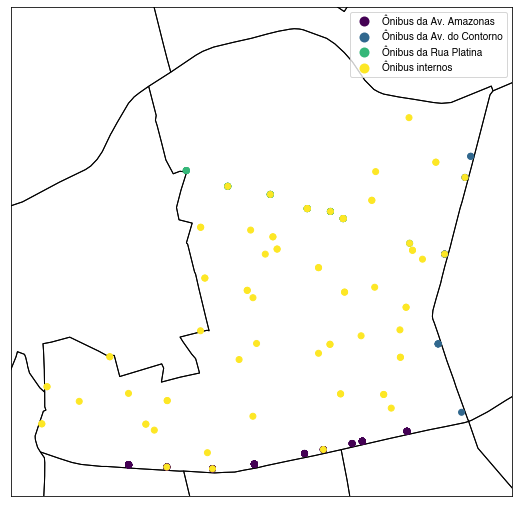

In [56]:
fig, ax = plt.subplots(1, 1,figsize=(10,9),)

ax=onibus_prado_cat.plot(ax=ax,categorical=True, column='cat',
                     cmap='viridis',legend=True)
bairro.plot(ax=ax,color='none',
           edgecolor='black',
           linewidth=1,
          zorder=-1)

### Grid
ax.set_xticks([])
ax.set_yticks([])

### Limites
bounds=quadra_prado.geometry.bounds
plt.xlim([bounds.minx.min()-100,bounds.maxx.max()+100])
plt.ylim([bounds.miny.min()-100,bounds.maxy.max()+100])

#vias_interesse.plot(ax=ax,color='red', linewidth=1)

plt.savefig('prado1.png', dpi=300, bbox_inches='tight')

In [49]:
quadra_prado['dist_amazonas']=(quadra_prado.geometry.apply(lambda x: onibus_prado_cat[onibus_prado_cat['cat']=='Ônibus da Av. Amazonas'].distance(x).min()))/1000
quadra_prado['dist_contorno']=(quadra_prado.geometry.apply(lambda x: onibus_prado_cat[onibus_prado_cat['cat']=='Ônibus da Av. do Contorno'].distance(x).min()))/1000
quadra_prado['dist_platina']=(quadra_prado.geometry.apply(lambda x: onibus_prado_cat[onibus_prado_cat['cat']=='Ônibus da Rua Platina'].distance(x).min()))/1000
quadra_prado['dist_internos']=(quadra_prado.geometry.apply(lambda x: onibus_prado_cat[onibus_prado_cat['cat']=='Ônibus internos'].distance(x).min()))/1000

In [50]:
quadra_prado['dist_media_onibus']=(quadra_prado['dist_amazonas']+quadra_prado['dist_contorno']+quadra_prado['dist_platina']+quadra_prado['dist_internos'])/4

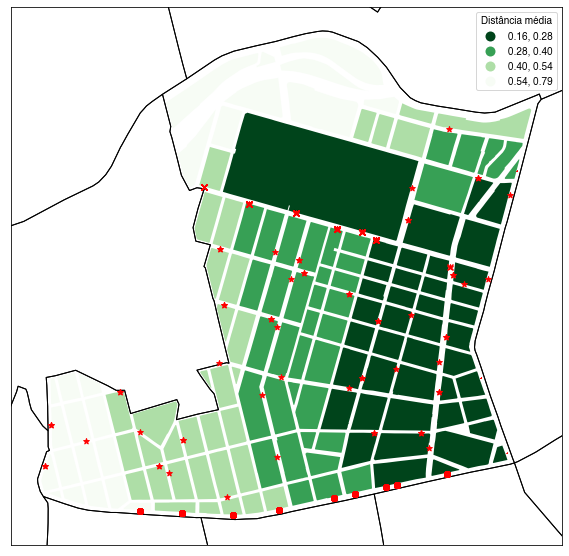

In [96]:
fig, ax = plt.subplots(1, 1,figsize=(11,9.9),)

ax=quadra_prado.plot(ax=ax,scheme='fisherjenks',column='dist_media_onibus',
                     cmap='Greens_r',k=4,legend=True)
onibus_prado_cat[onibus_prado_cat['cat']=='Ônibus da Av. Amazonas'].plot(ax=ax,color='red', 
                                                                         marker='o',)
onibus_prado_cat[onibus_prado_cat['cat']=='Ônibus da Av. do Contorno'].plot(ax=ax,color='red', 
                                                                         marker='+',
                                                                           markersize=1)
onibus_prado_cat[onibus_prado_cat['cat']=='Ônibus da Rua Platina'].plot(ax=ax,color='red', 
                                                                         marker='x',)
onibus_prado_cat[onibus_prado_cat['cat']=='Ônibus internos'].plot(ax=ax,color='red', 
                                                                         marker='*',)
bairro.plot(ax=ax,color='none',
           edgecolor='black',
           linewidth=1,
          zorder=-1)

leg = ax.get_legend()
#leg.set_bbox_to_anchor((1,0.34))
leg.set_title('Distância média')

### Grid
ax.set_xticks([])
ax.set_yticks([])

### Limites
bounds=quadra_prado.geometry.bounds
plt.xlim([bounds.minx.min()-100,bounds.maxx.max()+100])
plt.ylim([bounds.miny.min()-100,bounds.maxy.max()+100])

plt.savefig('prado2.png', dpi=300, bbox_inches='tight')

In [88]:
quadra_prado_onibus_top3 = quadra_prado.sort_values(by=['dist_media_onibus']).head(3)

(7795719.09461534, 7797473.19828204)

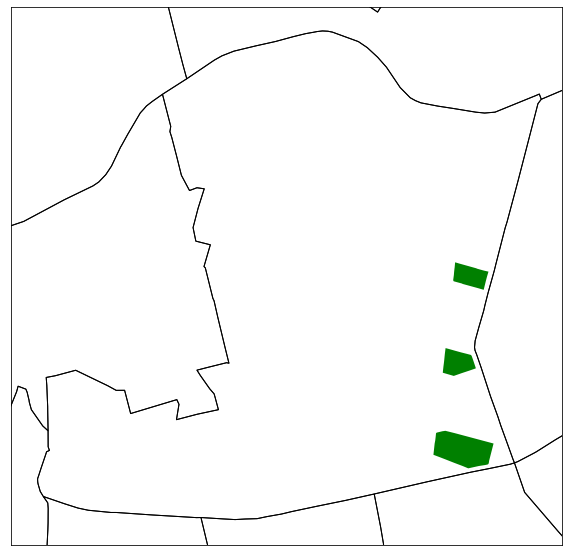

In [89]:
fig, ax = plt.subplots(1, 1,figsize=(11,9.9),)

ax=quadra_prado_onibus_top3.plot(ax=ax,color='green')
bairro.plot(ax=ax,color='none',
           edgecolor='black',
           linewidth=1,
          zorder=-1)

### Grid
ax.set_xticks([])
ax.set_yticks([])

### Limites
bounds=quadra_prado.geometry.bounds
plt.xlim([bounds.minx.min()-100,bounds.maxx.max()+100])
plt.ylim([bounds.miny.min()-100,bounds.maxy.max()+100])

<AxesSubplot:>

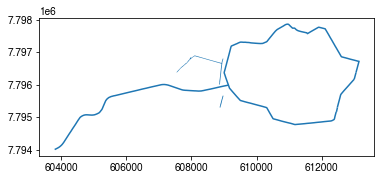

In [90]:
avenidas_interesse = vias[(vias['Nome']=='Av. Amazonas')|(vias['Nome']=='Av. do Contorno')]
vias_locais_interesse = vias_locais[(vias_locais['NOME_LOGRA']=='RUA PLATINA')|
                                    (vias_locais['NOME_LOGRA']=='AVENIDA FRANCISCO SA')]
vias_interesse = avenidas_interesse.append(vias_locais_interesse)
vias_interesse.plot()

In [91]:
quadra_prado['dist_vias_interesse']=(quadra_prado.geometry.apply(lambda x: vias_interesse.distance(x).min()))/1000
quadra_prado['quoficiente']=quadra_prado['dist_media_onibus']-quadra_prado['dist_vias_interesse']

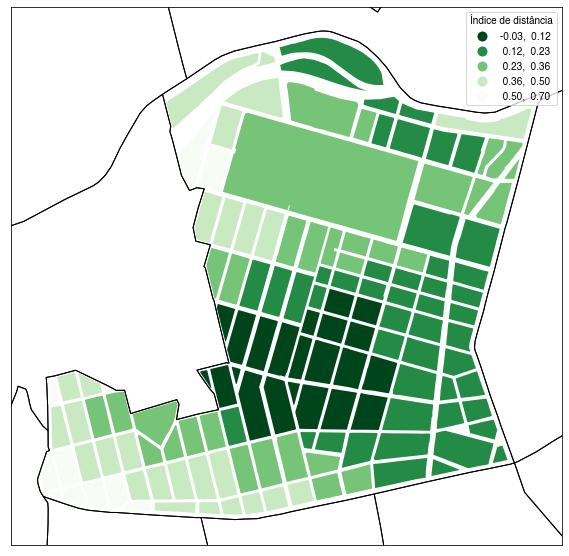

In [98]:
fig, ax = plt.subplots(1, 1,figsize=(11,9.9),)

ax=quadra_prado.plot(ax=ax,scheme='fisherjenks',column='quoficiente',
                     cmap='Greens_r',legend=True)
bairro.plot(ax=ax,color='none',
           edgecolor='black',
           linewidth=1,
          zorder=-1)

leg = ax.get_legend()
#leg.set_bbox_to_anchor((1,0.34))
leg.set_title('Índice de distância')

### Grid
ax.set_xticks([])
ax.set_yticks([])

### Limites
bounds=quadra_prado.geometry.bounds
plt.xlim([bounds.minx.min()-100,bounds.maxx.max()+100])
plt.ylim([bounds.miny.min()-100,bounds.maxy.max()+100])

plt.savefig('prado3.png', dpi=300, bbox_inches='tight')

In [93]:
quadra_prado_onibus_vias_top3 = quadra_prado.sort_values(by=['quoficiente']).head(2)

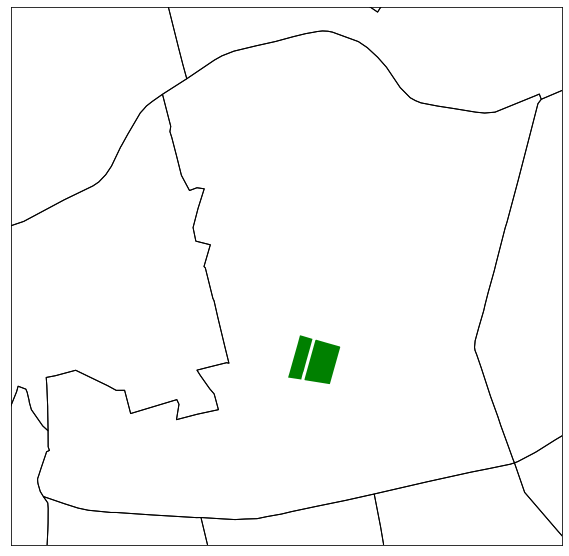

In [94]:
fig, ax = plt.subplots(1, 1,figsize=(11,9.9),)

ax=quadra_prado_onibus_vias_top3.plot(ax=ax,color='green')
bairro.plot(ax=ax,color='none',
           edgecolor='black',
           linewidth=1,
          zorder=-1)
#vias_locais_prado.plot(ax=ax,color='red',linewidth=1)
#vias_interesse.plot(ax=ax,color='red',linewidth=1)
#vias_locais[(vias_locais['NOME_LOGRA']=='RUA TURQUESA')].plot(ax=ax,color='red',linewidth=1)

### Grid
ax.set_xticks([])
ax.set_yticks([])

### Limites
bounds=quadra_prado.geometry.bounds
plt.xlim([bounds.minx.min()-100,bounds.maxx.max()+100])
plt.ylim([bounds.miny.min()-100,bounds.maxy.max()+100])

plt.savefig('prado4.png', dpi=300, bbox_inches='tight')